In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import seaborn as sns

In [2]:
### conexiones
import sys
sys.path.insert(0, "/home/jupyter")

%time
import ciphered_connections as connections
import getpass
from datetime import datetime

# path = getpass.getpass("PATH: ")
# key = getpass.getpass("KEY:  ")
# iv = getpass.getpass("IV:   ")

path = "/home/jupyter/ciphered_connections/000543781.dta"
key = "50bb801fa81378a538654b2b7076b223"
iv = "9029080389AF47F5"

# path: /home/jupyter/ciphered_connections/000543781.dta  
# key: 50bb801fa81378a538654b2b7076b223
# iv: 9029080389AF47F5

%time

conexion_bq = connections.BigQueryConnection(
    path_token = path, key = key, 
    iv = iv)
datetime_str = datetime.now().strftime("%Y%m%d%H%M%S")
table = "DATAMART.gcs_tabla_tiger_{0}".format(datetime_str)
bucket_object = "gcs_file_tiger_{0}_*.csv".format(datetime_str)
bucket_name = 'nbamasmovil'

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


In [3]:
# Descarga de tablón
query_decil = '''
    SELECT *                                  
    FROM  `bi-data-science-pilots.DESARROLLO.TABLON_1P_SEG_Comp_TRES_202006`
    where Decil < 3
        '''
TABLON_decil = conexion_bq.download_table_bq_gcs(query_decil,
    tabla_tmp = table, bucket_name = bucket_name,
    tmp_object = bucket_object)

TABLON_decil

Query results loaded to table /projects/bi-data-science-pilots/datasets/DATAMART/tables/gcs_tabla_tiger_20201112171510
Exported DATAMART.gcs_tabla_tiger_20201112171510 to gs://nbamasmovil/gcs_file_tiger_20201112171510_*.csv
Ejecutando la query:
 drop table `bi-data-science-pilots.DATAMART.gcs_tabla_tiger_20201112171510` ...

Query ejecutada correctamente


,YEAR,MONTH,EOP,BRAND_DS,CUSTOMER_ID,MIN_SERV_ACTIVATION_DATE,MAX_SERV_DEACTIVATION_DATE,NUM_ACCS_TOTA,NUM_ACCS_ACTI,NUM_ACCS_DEAC,...,Propension,VERSION,fuga_real,ISSUE_CALL,GB_EXCESO,Lineas_Exceso,Lineas_Poco_Uso,total_telefonos,DISCOUNT_VALUE_eur,FIN_DTO
0,2020,6,202006,YOIGO,8967323,2019-11-07,2020-02-12,1,0,0,...,0.854299,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,6,202006,YOIGO,9078520,2020-02-25,NaN,0,0,0,...,0.854602,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,6,202006,YOIGO,6568332,2015-02-12,2019-02-18,1,0,0,...,0.785650,2,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,2020,6,202006,YOIGO,4126585,2012-05-09,NaN,0,0,0,...,0.509193,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,6,202006,YOIGO,8643676,2019-01-17,NaN,0,0,0,...,0.571266,2,0,NaN,-5.000000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63590,2020,6,202006,YOIGO,7385424,2016-06-04,2020-05-20,2,1,1,...,0.583465,2,0,4.0,-1980.079750,0.0,0.0,5.0,220.0,0.0
63591,2020,6,202006,YOIGO,4240904,2012-06-26,2018-03-20,6,0,0,...,0.597988,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63592,2020,6,202006,YOIGO,1015384,2009-03-24,2017-05-16,6,1,0,...,0.554872,2,0,NaN,-2.516479,0.0,0.0,1.0,2.0,0.0
63593,2020,6,202006,YOIGO,7118083,2015-12-14,2020-02-10,4,0,0,...,0.542435,2,0,NaN,NaN,NaN,NaN,3.0,300.0,0.0


In [4]:
df=TABLON_decil.copy()

#### Tratamiento NULOS

In [5]:
df = df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('.'))
df.isnull().values.any()

False

In [6]:
df.isnull().values.any()

False

#### Filtramos variables numericas

In [7]:
import AYD
cadena=AYD.DS.DSC_Factor(df)
cadena_constantes = cadena[cadena.unique==1]           
eliminar_constantes=list(cadena_constantes['Variables'])

# Se añade a la lista variables de consentimiento
# ===================================================
eliminar_constantes.extend(['CONSENTSTATUSDETAIL','CONSENTSTATUSNAME','CONSENT_STATUS_DS','CONSENT_STATUS_DETAIL'] ) # variables gdpr 
eliminar_constantes.extend(['CUST_PREP_SEGMENT','MAIN_BRAND'] ) # variables desconocida
eliminar_constantes.extend(['CRM_WORK_TYPE'] ) # WORK TYPE, tenemos que recodificar bien
eliminar_constantes

['BRAND_DS',
 'CUST_BILL_POST_SEGMENT_CURR',
 'CUST_BUNDLE_CURR',
 'Bundle_Type',
 'Fecha_Predicion',
 'Modelo',
 'CONSENTSTATUSDETAIL',
 'CONSENTSTATUSNAME',
 'CONSENT_STATUS_DS',
 'CONSENT_STATUS_DETAIL',
 'CUST_PREP_SEGMENT',
 'MAIN_BRAND',
 'CRM_WORK_TYPE']

In [8]:
cadena=AYD.DS.DSC_Factor(df)
cadena.head()

,Variables,TIPO,count,nº_NA,Pcte_NA,unique,top,freq
0,BRAND_DS,Factor,191059,0,0,1,YOIGO,191059
1,MIN_SERV_ACTIVATION_DATE,Factor,191059,0,0,4555,2014-02-03,521
2,MAX_SERV_DEACTIVATION_DATE,Factor,191059,0,0,3638,.,118489
3,CUST_BILL_PREP_SEGMENT_CURR,Factor,191059,0,0,3,.,183201
4,CUST_BILL_POST_SEGMENT_CURR,Factor,191059,0,0,1,RESI,191059


In [9]:
# Se identifican variables constantes
# ===================================================
cadena_constantes = cadena[cadena.unique==1]           
eliminar_constantes=list(cadena_constantes['Variables'])
eliminar_constantes

['BRAND_DS',
 'CUST_BILL_POST_SEGMENT_CURR',
 'CUST_BUNDLE_CURR',
 'Bundle_Type',
 'Fecha_Predicion',
 'Modelo']

In [10]:
# Se añade a la lista variables de consentimiento
# ===================================================
# eliminar_constantes.extend(['CONSENTSTATUSDETAIL','CONSENTSTATUSNAME','CONSENT_STATUS_DS','CONSENT_STATUS_DETAIL'] ) # variables gdpr 
# eliminar_constantes.extend(['CUST_PREP_SEGMENT','MAIN_BRAND'] ) # variables desconocida
eliminar_constantes.extend(['CRM_WORK_TYPE'] ) # WORK TYPE, tenemos que recodificar bien
eliminar_constantes

['BRAND_DS',
 'CUST_BILL_POST_SEGMENT_CURR',
 'CUST_BUNDLE_CURR',
 'Bundle_Type',
 'Fecha_Predicion',
 'Modelo',
 'CRM_WORK_TYPE']

In [11]:
# Se eliminan las varibales seleccionadas
# ========================================
df.drop(eliminar_constantes, axis = 'columns',inplace=True) 
df

,YEAR,MONTH,EOP,CUSTOMER_ID,MIN_SERV_ACTIVATION_DATE,MAX_SERV_DEACTIVATION_DATE,NUM_ACCS_TOTA,NUM_ACCS_ACTI,NUM_ACCS_DEAC,NUM_ACCS_CURR,...,Propension,VERSION,fuga_real,ISSUE_CALL,GB_EXCESO,Lineas_Exceso,Lineas_Poco_Uso,total_telefonos,DISCOUNT_VALUE_eur,FIN_DTO
0,2020,6,202006,8967323,2019-11-07,2020-02-12,1,0,0,1,...,0.854299,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,2020,6,202006,9078520,2020-02-25,.,0,0,0,1,...,0.854602,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,2020,6,202006,6568332,2015-02-12,2019-02-18,1,0,0,1,...,0.785650,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,2020,6,202006,4126585,2012-05-09,.,0,0,0,1,...,0.509193,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,2020,6,202006,8643676,2019-01-17,.,0,0,0,1,...,0.571266,2,0,0.0,-5.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63590,2020,6,202006,7385424,2016-06-04,2020-05-20,2,1,1,2,...,0.583465,2,0,4.0,-1980.079750,0.0,0.0,5.0,220.0,0.0
63591,2020,6,202006,4240904,2012-06-26,2018-03-20,6,0,0,2,...,0.597988,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
63592,2020,6,202006,1015384,2009-03-24,2017-05-16,6,1,0,3,...,0.554872,2,0,0.0,-2.516479,0.0,0.0,1.0,2.0,0.0
63593,2020,6,202006,7118083,2015-12-14,2020-02-10,4,0,0,2,...,0.542435,2,0,0.0,0.000000,0.0,0.0,3.0,300.0,0.0


In [12]:
# Exclur fechas

fechas=list(cadena[cadena['Variables'].str.contains("DT")]['Variables']) 
fechas.extend(['CUSTOMER_ID'])
fechas

['CRM_BIRTH_DT',
 'LINE_TYPE_MAIN_PREP_ACT_LAST_DT',
 'LINE_TYPE_MAIN_PREP_DEA_LAST_DT',
 'LINE_TYPE_FIXE_POST_ACT_LAST_DT',
 'LINE_TYPE_MAIN_POST_ACT_LAST_DT',
 'LINE_TYPE_EXTR_POST_ACT_LAST_DT',
 'LINE_TYPE_ADDI_POST_ACT_LAST_DT',
 'LINE_TYPE_FIXE_POST_DEA_LAST_DT',
 'LINE_TYPE_MAIN_POST_DEA_LAST_DT',
 'LINE_TYPE_EXTR_POST_DEA_LAST_DT',
 'LINE_TYPE_ADDI_POST_DEA_LAST_DT',
 'CUSTOMER_ID']

In [13]:
df.drop(['CRM_BIRTH_DT',
 'LINE_TYPE_MAIN_PREP_ACT_LAST_DT', 'LINE_TYPE_MAIN_PREP_DEA_LAST_DT',
 'LINE_TYPE_FIXE_POST_ACT_LAST_DT', 'LINE_TYPE_MAIN_POST_ACT_LAST_DT',
 'LINE_TYPE_EXTR_POST_ACT_LAST_DT', 'LINE_TYPE_ADDI_POST_ACT_LAST_DT',
 'LINE_TYPE_FIXE_POST_DEA_LAST_DT', 'LINE_TYPE_MAIN_POST_DEA_LAST_DT',
 'LINE_TYPE_EXTR_POST_DEA_LAST_DT', 'LINE_TYPE_ADDI_POST_DEA_LAST_DT',
 'CUSTOMER_ID'], axis = 'columns',inplace=True) 
df

,YEAR,MONTH,EOP,MIN_SERV_ACTIVATION_DATE,MAX_SERV_DEACTIVATION_DATE,NUM_ACCS_TOTA,NUM_ACCS_ACTI,NUM_ACCS_DEAC,NUM_ACCS_CURR,NUM_BRAND_YOIGO_TOTA,...,Propension,VERSION,fuga_real,ISSUE_CALL,GB_EXCESO,Lineas_Exceso,Lineas_Poco_Uso,total_telefonos,DISCOUNT_VALUE_eur,FIN_DTO
0,2020,6,202006,2019-11-07,2020-02-12,1,0,0,1,1,...,0.854299,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,2020,6,202006,2020-02-25,.,0,0,0,1,0,...,0.854602,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,2020,6,202006,2015-02-12,2019-02-18,1,0,0,1,1,...,0.785650,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,2020,6,202006,2012-05-09,.,0,0,0,1,0,...,0.509193,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,2020,6,202006,2019-01-17,.,0,0,0,1,0,...,0.571266,2,0,0.0,-5.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63590,2020,6,202006,2016-06-04,2020-05-20,2,1,1,2,5,...,0.583465,2,0,4.0,-1980.079750,0.0,0.0,5.0,220.0,0.0
63591,2020,6,202006,2012-06-26,2018-03-20,6,0,0,2,6,...,0.597988,2,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
63592,2020,6,202006,2009-03-24,2017-05-16,6,1,0,3,6,...,0.554872,2,0,0.0,-2.516479,0.0,0.0,1.0,2.0,0.0
63593,2020,6,202006,2015-12-14,2020-02-10,4,0,0,2,6,...,0.542435,2,0,0.0,0.000000,0.0,0.0,3.0,300.0,0.0


In [14]:
numericas=AYD.DS.DSC(df)
numericas.head()

,Variables,TIPO,count,nº_NA,Pcte_NA,mean,std,min,25%,50%,75%,max,Var_near_zero
0,ACCO_BUND_MAX_ACTIVATION_DATE,Character,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,ACCO_BUND_MAX_DEACTIVATION_DATE,Character,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,ACCO_BUND_MIN_ACTIVATION_DATE,Character,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,ACCO_BUND_MIN_DEACTIVATION_DATE,Character,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,AVG_DL_PEAK_THR_KBPS_MOBI,Numeric,191059.0,0,0.0,20108.779054,13574.741232,0.0,11283.261111,19943.5,28030.174074,382897.0,False


In [15]:
numericas.shape

(1114, 13)

In [16]:
#eliminar todas la variables con la palabra busi y soho
eliminar=list(numericas[numericas['Variables'].str.contains("BUSI|SOHO|FIX|GDPR|FTTH|ADSL|2P|FMC|PRE|FECHA|DATE" ,case=False)]['Variables']) 
eliminar.extend(['EOP','GDPR_NEVER_CALL','MONTH','Propension','YEAR','Percentil','VERSION','Decil'])  # variables gdpr 

df.drop(eliminar, axis = 'columns', inplace=True)
df_num=df
df_num

,NUM_ACCS_TOTA,NUM_ACCS_ACTI,NUM_ACCS_DEAC,NUM_ACCS_CURR,NUM_BRAND_YOIGO_TOTA,NUM_BRAND_YOIGO_ACTI,NUM_BRAND_YOIGO_DEAC,NUM_BRAND_YOIGO_CURR,IS_CUST_BRAND_YOIGO_CURR,NUM_BRAND_MASMOVIL_TOTA,...,Jiras_Reclamacion_Movil,Mobile_Red_Incidences,fuga_real,ISSUE_CALL,GB_EXCESO,Lineas_Exceso,Lineas_Poco_Uso,total_telefonos,DISCOUNT_VALUE_eur,FIN_DTO
0,1,0,0,1,1,0,0,1,True,0,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0,1,True,0,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,1,0,0,1,1,0,0,1,True,0,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0,0,0,1,0,0,0,1,True,0,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0,0,0,1,0,0,0,1,True,0,...,0.0,0.0,0,0.0,-5.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63590,2,1,1,2,5,0,0,3,True,0,...,0.0,0.0,0,4.0,-1980.079750,0.0,0.0,5.0,220.0,0.0
63591,6,0,0,2,6,0,0,2,True,0,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
63592,6,1,0,3,6,0,0,3,True,0,...,0.0,0.0,0,0.0,-2.516479,0.0,0.0,1.0,2.0,0.0
63593,4,0,0,2,6,0,0,2,True,0,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,3.0,300.0,0.0


#### Comprobamos existencia de variables concretas

In [17]:
# Verificamos que las variables que necesitamos están en el tablón

def verificar(var):
    variables_TOTAL=pd.DataFrame(list(df.columns.values)) 
    variables_TOTAL[['Variables']]=variables_TOTAL[[0]]
    validar=list(variables_TOTAL[variables_TOTAL['Variables'].str.contains(var,case=False)]['Variables']) 
    return validar

verificar("Jiras_Reclamacion_Movil")

['Jiras_Reclamacion_Movil']

In [18]:
df_muestra=df_num.sample(n=10000, random_state=1)
df_muestra

,MIN_SERV_ACTIVATION_DATE,MAX_SERV_DEACTIVATION_DATE,NUM_ACCS_TOTA,NUM_ACCS_ACTI,NUM_ACCS_DEAC,NUM_ACCS_CURR,NUM_BRAND_YOIGO_TOTA,NUM_BRAND_YOIGO_ACTI,NUM_BRAND_YOIGO_DEAC,NUM_BRAND_YOIGO_CURR,...,Jiras_Reclamacion_Movil,Mobile_Red_Incidences,fuga_real,ISSUE_CALL,GB_EXCESO,Lineas_Exceso,Lineas_Poco_Uso,total_telefonos,DISCOUNT_VALUE_eur,FIN_DTO
23300,2015-05-13,.,1,0,0,1,1,0,0,1,...,0.0,0.0,1,0.0,1.196540,1.0,0.0,0.0,0.0,0.0
21698,2016-10-26,.,1,0,0,1,1,0,0,1,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,1.0,20.0,0.0
63222,2016-07-21,.,1,0,0,1,1,0,0,1,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,1.0,20.0,0.0
62619,2010-04-03,2010-09-02,2,0,0,1,2,0,0,1,...,0.0,0.0,0,0.0,5.327565,1.0,0.0,0.0,0.0,0.0
6095,2011-06-27,.,0,0,0,1,0,0,0,1,...,0.0,0.0,0,0.0,1.031291,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49158,2015-12-31,.,1,0,0,1,1,0,0,1,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,3.0,120.0,0.0
24725,2014-06-26,.,0,0,0,1,0,0,0,1,...,0.0,0.0,0,0.0,-10.975449,0.0,1.0,0.0,0.0,0.0
27003,2012-10-08,.,1,1,0,1,1,0,0,1,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
31066,2011-05-19,2011-07-18,2,0,0,1,2,0,0,1,...,0.0,0.0,0,0.0,-4.570648,0.0,1.0,0.0,0.0,0.0


In [17]:
762 + 11251

12013

In [19]:
#### Definición del segmento
# 'BILLING_CLAIMS' -->  when ticket_type like '%Reclamación%' and tipology in ('Recarga','Cobros','Desacuerdos','Promoción mal Aplicada') 
# 'CLAIMS', --> when ticket_type like '%Reclamación%' then 1 else 0 end as Claims, 
# 'Jiras_Reclamacion_Movil', -->
    #   sum(case when (issuetype like '%No he podido usar mi móvil%' or issuetype like '%Se registra en red pero no tiene servicio%' 
    #   or issuetype like '%Problemas Durante el proceso de Portabilidad%' 
    #   or issuetype like '%Roto%' 
    #   or issuetype like '%No recibe llamadas de fijos%' 
    #   or issuetype like '%Instalación / Provisión%' 
    #   or issuetype like '%No funciona internet%' 
    #   or issuetype like '%Problemas de Terminal%' 
    # )     then 1 else 0 end) as Jiras_Reclamacion_Movil,
# 'Mobile_Red_Incidences', -->
    # sum(case when project_pkey in ('CC', 'MM') and issuetype = 'Error en la línea' and line_error_type in ('Compartir-no compartir internet', 'Error activación nueva numeración', 'Error al cambiar el ICC', 
    # 'Error en MySim durante la portabilidad', 'Error en MySim tras la portabilidad', 
    # 'Es el primer dia en Yoigo y no tiene servicio', 'Estado Instalado sin expedición', 
    # 'No puede navegar porque salta Landig Page', 'No se puede poner / quitar Bloqueo', 
    # 'No se puede poner/quitar bloqueo', 'Problema activación de ICC', 'Problema con Bonos',
    # 'Problemas con bonos y ampliaciones', 'Problemas con la Recarga', 'Problemas con línea PREPAGO', 
    # 'Reactivar línea', 'Recuperar baja manual errónea', 'Recuperar baja móvil manual errónea', 'Recuperar línea por error del sistema', 
    # 'Relanzar portabilidad', 'Problema cambio SIM') then 1 else 0 end) as Mobile_Red_Incidences

# 'ISSUE_CALL', -->
 # case when B.issue_call is true then 'SI' WHEN B.issue_call is false then 'NO' END AS ISSUE_CALL
# 'NUM_LLAMADAS_PROCESS'  -->


In [20]:
# Filtramos el tablon por las variables que definen el segmento
tablon_issue = df_muestra.loc[:, ('BILLING_CLAIMS',
 'CLAIMS',
 'Jiras_Reclamacion_Movil',
 'ISSUE_CALL',
 'NUM_LLAMADAS_PROCESS',
 'fuga_real')]
  
# ===============================================
corr = tablon_issue.corr()
cor_var= corr[['fuga_real']].sort_values(by = 'fuga_real',ascending = False)

# la salida NaN  imlica que la muestra no contempla todos las categorias para la variable.

In [21]:
# Correlacion con las variables destacada por definición
# ===============================================
corr = df_muestra.corr()
corr


,NUM_ACCS_TOTA,NUM_ACCS_ACTI,NUM_ACCS_DEAC,NUM_ACCS_CURR,NUM_BRAND_YOIGO_TOTA,NUM_BRAND_YOIGO_ACTI,NUM_BRAND_YOIGO_DEAC,NUM_BRAND_YOIGO_CURR,IS_CUST_BRAND_YOIGO_CURR,NUM_BRAND_MASMOVIL_TOTA,...,Jiras_Reclamacion_Movil,Mobile_Red_Incidences,fuga_real,ISSUE_CALL,GB_EXCESO,Lineas_Exceso,Lineas_Poco_Uso,total_telefonos,DISCOUNT_VALUE_eur,FIN_DTO
NUM_ACCS_TOTA,1.000000,0.012770,0.089445,0.108967,0.943766,-0.089932,0.043078,0.165682,NaN,NaN,...,0.002446,-0.006130,-0.013933,0.017428,-0.011104,-0.031902,-0.007229,0.080666,0.077096,0.001865
NUM_ACCS_ACTI,0.012770,1.000000,0.438383,0.140379,0.027553,0.484366,0.130096,0.127678,NaN,NaN,...,0.005544,0.032222,-0.008388,0.091825,-0.496186,-0.070440,-0.061729,0.132695,0.094035,0.174848
NUM_ACCS_DEAC,0.089445,0.438383,1.000000,-0.347608,0.108093,0.005284,0.271822,0.073865,NaN,NaN,...,-0.007463,-0.007463,-0.023239,0.066771,-0.445562,-0.032913,0.068008,0.161158,0.120444,0.076857
NUM_ACCS_CURR,0.108967,0.140379,-0.347608,1.000000,0.136839,0.138381,-0.055185,0.679765,NaN,NaN,...,0.011509,0.011509,-0.005515,0.014714,-0.047372,0.023298,0.008113,0.093138,0.078792,0.030777
NUM_BRAND_YOIGO_TOTA,0.943766,0.027553,0.108093,0.136839,1.000000,-0.080157,0.102614,0.227228,NaN,NaN,...,0.000536,-0.006970,-0.009762,0.026942,-0.024871,-0.035395,-0.027761,0.162460,0.187130,0.011608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lineas_Exceso,-0.031902,-0.070440,-0.032913,0.023298,-0.035395,-0.039813,-0.007065,0.024964,NaN,NaN,...,-0.006528,0.026710,0.036502,-0.003475,0.073477,1.000000,-0.116206,-0.023709,-0.026730,-0.006351
Lineas_Poco_Uso,-0.007229,-0.061729,0.068008,0.008113,-0.027761,-0.061643,-0.002930,0.083504,NaN,NaN,...,-0.008439,-0.008439,0.001430,-0.027838,0.067541,-0.116206,1.000000,-0.000782,-0.026398,-0.014335
total_telefonos,0.080666,0.132695,0.161158,0.093138,0.162460,-0.000277,0.059290,0.168603,NaN,NaN,...,-0.007094,-0.000814,-0.021609,0.049332,-0.238258,-0.023709,-0.000782,1.000000,0.806954,0.241167
DISCOUNT_VALUE_eur,0.077096,0.094035,0.120444,0.078792,0.187130,0.001389,0.122158,0.170436,NaN,NaN,...,-0.006534,-0.000578,-0.005814,0.050840,-0.122897,-0.026730,-0.026398,0.806954,1.000000,0.202871


In [ ]:
DESDE CABIAR 0,3 POR ALGO MAS PEQUEÑO

In [21]:
cor_var= corr[['Jiras_Reclamacion_Movil']].sort_values(by = 'Jiras_Reclamacion_Movil',ascending = False)
SEG_PROCESS_ISSUE= cor_var[cor_var['Jiras_Reclamacion_Movil']>=0.3]
SEG_PROCESS_ISSUE

,Jiras_Reclamacion_Movil
Jiras_Reclamacion_Movil,1.000000
MOBILE_INCIDENCES,0.432736


In [22]:
seg1_lista_1= list(SEG_PROCESS_ISSUE.T)
seg1_lista_1

['Jiras_Reclamacion_Movil', 'MOBILE_INCIDENCES']

#### elaboramos un segundo listado

In [23]:
cor_var= corr[['CLAIMS']].sort_values(by = 'CLAIMS',ascending = False)
SEG_PROCESS_ISSUE= cor_var[cor_var['CLAIMS']>=0.2]
SEG_PROCESS_ISSUE

,CLAIMS
CLAIMS,1.000000
TOTAL_BLUE_TICKETS,0.816385
BILLING_CLAIMS,0.763315
tiempo_hr_resolucion_incidencia,0.597679
tiempo_hr_resolucion_reclamacion,0.597679
total_jiras_cc,0.284978


In [24]:
seg1_lista_2= list(SEG_PROCESS_ISSUE.T)
seg1_lista_2

['CLAIMS',
 'TOTAL_BLUE_TICKETS',
 'BILLING_CLAIMS',
 'tiempo_hr_resolucion_incidencia',
 'tiempo_hr_resolucion_reclamacion',
 'total_jiras_cc']

#### elaboramos un tercer listado

In [25]:
cor_var= corr[['ISSUE_CALL']].sort_values(by = 'ISSUE_CALL',ascending = False)
SEG_PROCESS_ISSUE= cor_var[cor_var['ISSUE_CALL']>=0.5]
SEG_PROCESS_ISSUE

,ISSUE_CALL
ISSUE_CALL,1.000000
MOSAIC_NUM_COMM_WITH_ISSUE_CURR,0.874302
MOSAIC_NUM_COMM_DEPT_ATC_CURR,0.800521
IVR_NUM_SECS_TALK_TIME,0.790937
MOSAIC_NUM_COMM_WP_GRP_NON_TECH_CURR,0.782701
IVR_NUM_AGENT,0.750136
IVR_NUM_ACD,0.744899
MOSAIC_NUM_COMMS_CURR,0.742392
IVR_NUM_SECS_TOTAL,0.741111
IVR_NUM_AGEN,0.740756


In [26]:
seg1_lista_3= list(SEG_PROCESS_ISSUE.T)
seg1_lista_3

['ISSUE_CALL',
 'MOSAIC_NUM_COMM_WITH_ISSUE_CURR',
 'MOSAIC_NUM_COMM_DEPT_ATC_CURR',
 'IVR_NUM_SECS_TALK_TIME',
 'MOSAIC_NUM_COMM_WP_GRP_NON_TECH_CURR',
 'IVR_NUM_AGENT',
 'IVR_NUM_ACD',
 'MOSAIC_NUM_COMMS_CURR',
 'IVR_NUM_SECS_TOTAL',
 'IVR_NUM_AGEN',
 'IVR_NUM_CALL_TRAN',
 'MOSAIC_NUM_COMM_WP_GRP_NO_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_NO_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_UNKN_CURR',
 'MOSAIC_NUM_COMM_WITHOUT_ISSUE_CURR',
 'IVR_NUM_RECA_AGEN',
 'IVR_NUM_SEGM',
 'IVR_NUM_SECS_WAIT_TIME',
 'IVR_NUM_SECS_TOTA_WAIT',
 'IVR_NUM_TOTA_WAIT_MORE_5MIN',
 'IVR_NUM_PART_WAIT_MORE_5MIN',
 'IVR_NUM_OUT_CALL_CENTER',
 'IVR_NUM_MDTEL',
 'IVR_NUM_SAME_ORIGIN',
 'IVR_NUM_CALL_IN',
 'IVR_NUM_CALLS',
 'IVR_NUM_RECA',
 'IVR_NUM_YDILO',
 'IVR_IS_AFTE',
 'IVR_NUM_WEDN',
 'NUM_LLAMADAS_HEAVY_CALLERS',
 'IVR_IS_NIGH',
 'NUM_LLAMADAS_PROCESS',
 'IVR_NUM_HOUR_20',
 'MOSAIC_NUM_COMM_WP_OTHERS_CURR',
 'IVR_NUM_HOUR_13',
 'IVR_NUM_THUR',
 'IVR_NUM_HOUR_14',
 'MOSAIC_NUM_COMM_WP_GRP_TECH_CURR']

#### elaboramos un cuarto listado

In [27]:
cor_var= corr[['NUM_LLAMADAS_PROCESS']].sort_values(by = 'NUM_LLAMADAS_PROCESS',ascending = False)
SEG_PROCESS_ISSUE= cor_var[cor_var['NUM_LLAMADAS_PROCESS']>=0.5]
SEG_PROCESS_ISSUE

,NUM_LLAMADAS_PROCESS
NUM_LLAMADAS_PROCESS,1.000000
IVR_NUM_SEGM,0.855393
IVR_NUM_YDILO,0.807326
IVR_NUM_ACD,0.806899
IVR_NUM_CALL_TRAN,0.799632
IVR_NUM_MDTEL,0.798901
IVR_NUM_CALLS,0.798458
IVR_NUM_CALL_IN,0.798458
IVR_NUM_RECA,0.794692
IVR_NUM_AGENT,0.794211


In [28]:
seg1_lista_4= list(SEG_PROCESS_ISSUE.T)
seg1_lista_4

['NUM_LLAMADAS_PROCESS',
 'IVR_NUM_SEGM',
 'IVR_NUM_YDILO',
 'IVR_NUM_ACD',
 'IVR_NUM_CALL_TRAN',
 'IVR_NUM_MDTEL',
 'IVR_NUM_CALLS',
 'IVR_NUM_CALL_IN',
 'IVR_NUM_RECA',
 'IVR_NUM_AGENT',
 'IVR_NUM_AGEN',
 'IVR_NUM_SAME_ORIGIN',
 'IVR_NUM_SECS_TOTAL',
 'IVR_NUM_RECA_AGEN',
 'IVR_IS_AFTE',
 'IVR_NUM_SECS_TALK_TIME',
 'MOSAIC_NUM_COMMS_CURR',
 'MOSAIC_NUM_COMM_WP_NO_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_NO_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_UNKN_CURR',
 'IVR_IS_NIGH',
 'IVR_NUM_SECS_WAIT_TIME',
 'IVR_NUM_SECS_TOTA_WAIT',
 'MOSAIC_NUM_COMM_DEPT_ATC_CURR',
 'IVR_NUM_WEDN',
 'MOSAIC_NUM_COMM_WITHOUT_ISSUE_CURR',
 'IVR_NUM_PART_WAIT_MORE_5MIN',
 'IVR_NUM_TOTA_WAIT_MORE_5MIN',
 'IVR_NUM_OUT_CALL_CENTER',
 'IVR_NUM_MOND',
 'NUM_LLAMADAS_HEAVY_CALLERS',
 'IVR_NUM_THUR',
 'IVR_NUM_HOUR_13',
 'IVR_NUM_HOUR_20',
 'IVR_NUM_FRID',
 'IVR_NUM_HOUR_14',
 'IVR_NUM_HOUR_15',
 'IVR_NUM_HOUR_21',
 'IVR_NUM_HOUR_12',
 'ISSUE_CALL',
 'IVR_IS_MORN',
 'IVR_NUM_HOUR_19']

In [29]:
# unir las tres listas y sacar un arbor

In [30]:
# creamos una lista unica con todos los elementos
seg1_lista_1.extend(seg1_lista_2)
seg1_lista_1.extend(seg1_lista_3)
seg1_lista_1.extend(seg1_lista_4)
seg1_lista_1

['Jiras_Reclamacion_Movil',
 'MOBILE_INCIDENCES',
 'CLAIMS',
 'TOTAL_BLUE_TICKETS',
 'BILLING_CLAIMS',
 'tiempo_hr_resolucion_incidencia',
 'tiempo_hr_resolucion_reclamacion',
 'total_jiras_cc',
 'ISSUE_CALL',
 'MOSAIC_NUM_COMM_WITH_ISSUE_CURR',
 'MOSAIC_NUM_COMM_DEPT_ATC_CURR',
 'IVR_NUM_SECS_TALK_TIME',
 'MOSAIC_NUM_COMM_WP_GRP_NON_TECH_CURR',
 'IVR_NUM_AGENT',
 'IVR_NUM_ACD',
 'MOSAIC_NUM_COMMS_CURR',
 'IVR_NUM_SECS_TOTAL',
 'IVR_NUM_AGEN',
 'IVR_NUM_CALL_TRAN',
 'MOSAIC_NUM_COMM_WP_GRP_NO_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_NO_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_UNKN_CURR',
 'MOSAIC_NUM_COMM_WITHOUT_ISSUE_CURR',
 'IVR_NUM_RECA_AGEN',
 'IVR_NUM_SEGM',
 'IVR_NUM_SECS_WAIT_TIME',
 'IVR_NUM_SECS_TOTA_WAIT',
 'IVR_NUM_TOTA_WAIT_MORE_5MIN',
 'IVR_NUM_PART_WAIT_MORE_5MIN',
 'IVR_NUM_OUT_CALL_CENTER',
 'IVR_NUM_MDTEL',
 'IVR_NUM_SAME_ORIGIN',
 'IVR_NUM_CALL_IN',
 'IVR_NUM_CALLS',
 'IVR_NUM_RECA',
 'IVR_NUM_YDILO',
 'IVR_IS_AFTE',
 'IVR_NUM_WEDN',
 'NUM_LLAMADAS_HEAVY_CALLERS',
 'IVR_IS_NIG

In [31]:
seg1_lista_1.extend(['fuga_real']) # se añaden elemento a la lista que no salian en una primera iteraccion
seg1_lista_1

['Jiras_Reclamacion_Movil',
 'MOBILE_INCIDENCES',
 'CLAIMS',
 'TOTAL_BLUE_TICKETS',
 'BILLING_CLAIMS',
 'tiempo_hr_resolucion_incidencia',
 'tiempo_hr_resolucion_reclamacion',
 'total_jiras_cc',
 'ISSUE_CALL',
 'MOSAIC_NUM_COMM_WITH_ISSUE_CURR',
 'MOSAIC_NUM_COMM_DEPT_ATC_CURR',
 'IVR_NUM_SECS_TALK_TIME',
 'MOSAIC_NUM_COMM_WP_GRP_NON_TECH_CURR',
 'IVR_NUM_AGENT',
 'IVR_NUM_ACD',
 'MOSAIC_NUM_COMMS_CURR',
 'IVR_NUM_SECS_TOTAL',
 'IVR_NUM_AGEN',
 'IVR_NUM_CALL_TRAN',
 'MOSAIC_NUM_COMM_WP_GRP_NO_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_NO_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_UNKN_CURR',
 'MOSAIC_NUM_COMM_WITHOUT_ISSUE_CURR',
 'IVR_NUM_RECA_AGEN',
 'IVR_NUM_SEGM',
 'IVR_NUM_SECS_WAIT_TIME',
 'IVR_NUM_SECS_TOTA_WAIT',
 'IVR_NUM_TOTA_WAIT_MORE_5MIN',
 'IVR_NUM_PART_WAIT_MORE_5MIN',
 'IVR_NUM_OUT_CALL_CENTER',
 'IVR_NUM_MDTEL',
 'IVR_NUM_SAME_ORIGIN',
 'IVR_NUM_CALL_IN',
 'IVR_NUM_CALLS',
 'IVR_NUM_RECA',
 'IVR_NUM_YDILO',
 'IVR_IS_AFTE',
 'IVR_NUM_WEDN',
 'NUM_LLAMADAS_HEAVY_CALLERS',
 'IVR_IS_NIG

In [32]:
tablon_filtrado_ML=df_muestra.loc[:,list(seg1_lista_1)]
tablon_filtrado_ML

,Jiras_Reclamacion_Movil,MOBILE_INCIDENCES,CLAIMS,TOTAL_BLUE_TICKETS,BILLING_CLAIMS,tiempo_hr_resolucion_incidencia,tiempo_hr_resolucion_reclamacion,total_jiras_cc,ISSUE_CALL,MOSAIC_NUM_COMM_WITH_ISSUE_CURR,...,IVR_NUM_HOUR_20,IVR_NUM_FRID,IVR_NUM_HOUR_14,IVR_NUM_HOUR_15,IVR_NUM_HOUR_21,IVR_NUM_HOUR_12,ISSUE_CALL,IVR_IS_MORN,IVR_NUM_HOUR_19,fuga_real
23320,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
21698,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
63242,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
62611,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
6095,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49178,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
24745,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0.0,0,0
26995,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0.0,0,1
31086,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0.0,0.0,0,0


### Matriz de correlaciones

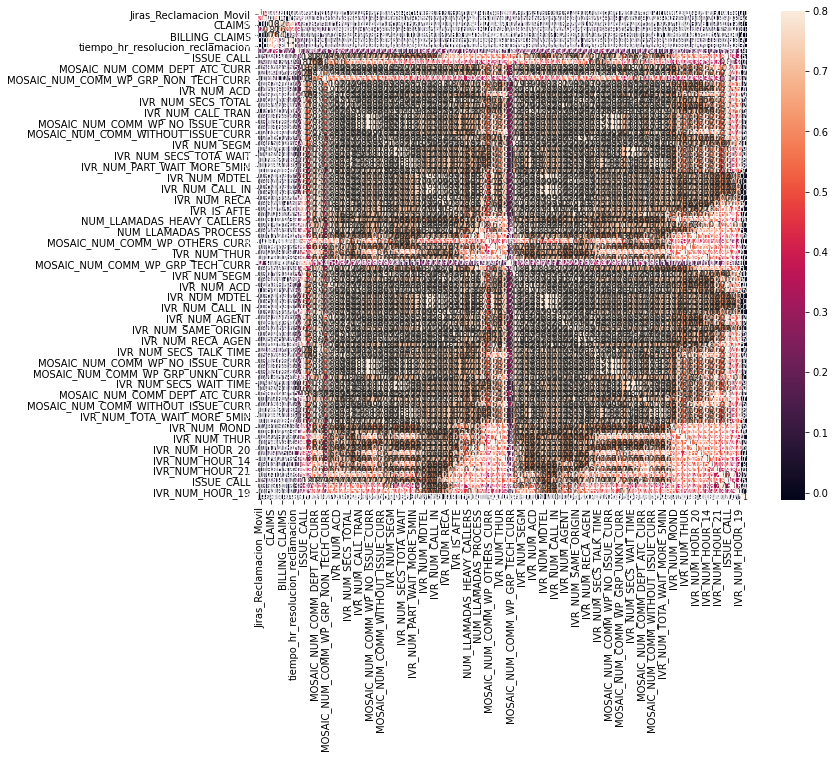

In [33]:
corrmat = tablon_filtrado_ML.corr() #df_corelacion.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,annot = True, annot_kws = {'size': 8});

In [34]:
# Desde este punto se trabaja con el tablón con todos los registros
df.shape[0]

191059

#### Seleccón de variables

In [35]:
df

,MIN_SERV_ACTIVATION_DATE,MAX_SERV_DEACTIVATION_DATE,NUM_ACCS_TOTA,NUM_ACCS_ACTI,NUM_ACCS_DEAC,NUM_ACCS_CURR,NUM_BRAND_YOIGO_TOTA,NUM_BRAND_YOIGO_ACTI,NUM_BRAND_YOIGO_DEAC,NUM_BRAND_YOIGO_CURR,...,Jiras_Reclamacion_Movil,Mobile_Red_Incidences,fuga_real,ISSUE_CALL,GB_EXCESO,Lineas_Exceso,Lineas_Poco_Uso,total_telefonos,DISCOUNT_VALUE_eur,FIN_DTO
0,2017-07-25,.,0,0,0,1,0,0,0,1,...,0.0,0.0,0,0.0,-4.999838,0.0,1.0,0.0,0.00,0.0
1,2019-07-17,.,0,0,0,1,0,0,0,1,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0
2,2019-08-09,2019-11-27,1,0,0,1,1,0,0,1,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0
3,2018-10-16,.,0,0,0,1,0,0,0,1,...,0.0,0.0,0,0.0,-1.998243,0.0,1.0,0.0,0.00,0.0
4,2012-12-18,.,1,0,0,1,1,0,0,1,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63575,2009-06-24,2020-02-18,15,1,0,2,20,0,0,2,...,0.0,0.0,0,0.0,-1.966909,0.0,1.0,1.0,20.00,0.0
63576,2008-08-22,2020-01-16,19,1,0,2,21,0,0,2,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,3.0,85.26,0.0
63577,2008-01-07,2020-06-16,25,2,1,2,29,2,0,2,...,0.0,0.0,0,0.0,-992.726407,0.0,0.0,1.0,35.90,0.0
63578,2010-02-16,2018-10-23,94,0,0,34,94,0,0,34,...,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0


In [36]:
X=df[
    
['Jiras_Reclamacion_Movil',
 'Incidencias_High_Priority',
 'MOSAIC_NUM_COMM_WP_MOB_FAULT_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_TECH_CURR',
 'ISSUE_CALL',
 'CLAIMS',
 'BILLING_CLAIMS',
 'TOTAL_BLUE_TICKETS',
 'total_jiras_cc',
 'tiempo_hr_resolucion_incidencia',
 'tiempo_hr_resolucion_reclamacion',
 'IVR_NUM_SECS_TALK_TIME',
 'IVR_NUM_AGENT',
 'ISSUE_CALL',
 'IVR_NUM_SECS_TOTAL',
 'MAX_IVR_NUM_SECS_TALK_TIME',
 'MOSAIC_NUM_COMM_DEPT_FAULT_CURR',
 'IVR_NUM_AGEN',
 'ISSUE_CALL',
 'MOSAIC_NUM_COMM_WITH_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_NON_TECH_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_TECH_CURR',
 'MOSAIC_NUM_COMM_DEPT_ATC_CURR',
 'IVR_NUM_SECS_TALK_TIME',
 'MOSAIC_NUM_COMM_WP_CUSTOMER_CURR',
 'MOSAIC_NUM_COMMS_CURR',
 'NUM_LLAMADAS_PROCESS',
 'IVR_NUM_SEGM',
 'IVR_NUM_YDILO',
 'IVR_NUM_CALLS',
 'IVR_NUM_CALL_IN',
 'IVR_NUM_MDTEL',
 'IVR_NUM_RECA',
 'IVR_NUM_SAME_ORIGIN',
 'IVR_NUM_CALL_TRAN',
 'IVR_IS_AFTE',
 'IVR_NUM_RECA_AGEN',
 'IVR_NUM_SECS_TOTAL',
 'IVR_NUM_AGEN',
 'IVR_NUM_ACD',
 'IVR_NUM_AGENT',
 'MAX_IVR_NUM_SEGM',
 'MOSAIC_NUM_COMMS_CURR',
 'MAX_IVR_NUM_SECS_TOTAL',
 'MAX_IVR_NUM_AGEN',
 'IVR_NUM_MOND',
 'IVR_IS_NIGH',
 'fuga_real'
 
  ]]


Y=df[['fuga_real']].astype(str)

In [37]:
cs=sorted(X)
cs

['BILLING_CLAIMS',
 'CLAIMS',
 'ISSUE_CALL',
 'ISSUE_CALL',
 'ISSUE_CALL',
 'IVR_IS_AFTE',
 'IVR_IS_NIGH',
 'IVR_NUM_ACD',
 'IVR_NUM_AGEN',
 'IVR_NUM_AGEN',
 'IVR_NUM_AGENT',
 'IVR_NUM_AGENT',
 'IVR_NUM_CALLS',
 'IVR_NUM_CALL_IN',
 'IVR_NUM_CALL_TRAN',
 'IVR_NUM_MDTEL',
 'IVR_NUM_MOND',
 'IVR_NUM_RECA',
 'IVR_NUM_RECA_AGEN',
 'IVR_NUM_SAME_ORIGIN',
 'IVR_NUM_SECS_TALK_TIME',
 'IVR_NUM_SECS_TALK_TIME',
 'IVR_NUM_SECS_TOTAL',
 'IVR_NUM_SECS_TOTAL',
 'IVR_NUM_SEGM',
 'IVR_NUM_YDILO',
 'Incidencias_High_Priority',
 'Jiras_Reclamacion_Movil',
 'MAX_IVR_NUM_AGEN',
 'MAX_IVR_NUM_SECS_TALK_TIME',
 'MAX_IVR_NUM_SECS_TOTAL',
 'MAX_IVR_NUM_SEGM',
 'MOSAIC_NUM_COMMS_CURR',
 'MOSAIC_NUM_COMMS_CURR',
 'MOSAIC_NUM_COMM_DEPT_ATC_CURR',
 'MOSAIC_NUM_COMM_DEPT_FAULT_CURR',
 'MOSAIC_NUM_COMM_WITH_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_CUSTOMER_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_NON_TECH_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_TECH_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_TECH_CURR',
 'MOSAIC_NUM_COMM_WP_MOB_FAULT_CURR',
 'NUM_LL

In [38]:
X=df[['BILLING_CLAIMS',
 'CLAIMS',
 'ISSUE_CALL',
 'IVR_IS_AFTE',
 'IVR_IS_NIGH',
 'IVR_NUM_ACD',
 'IVR_NUM_AGEN',  
 'IVR_NUM_AGENT', # Total de agente por los que ha pasado el agente
 'IVR_NUM_CALLS',
 'IVR_NUM_CALL_IN',
 'IVR_NUM_CALL_TRAN',
 'IVR_NUM_MDTEL',
 'IVR_NUM_MOND',
 'IVR_NUM_RECA',
 'IVR_NUM_RECA_AGEN',
 'IVR_NUM_SAME_ORIGIN',
 'IVR_NUM_SECS_TALK_TIME',
 'IVR_NUM_SECS_TOTAL',
 'IVR_NUM_SEGM',
 'IVR_NUM_YDILO',
 'Incidencias_High_Priority',
 'Jiras_Reclamacion_Movil',
 'MAX_IVR_NUM_AGEN',
 'MAX_IVR_NUM_SECS_TALK_TIME',
 'MAX_IVR_NUM_SECS_TOTAL',
 'MAX_IVR_NUM_SEGM',
 'MOSAIC_NUM_COMMS_CURR',
 'MOSAIC_NUM_COMM_DEPT_ATC_CURR',
 'MOSAIC_NUM_COMM_DEPT_FAULT_CURR',
 'MOSAIC_NUM_COMM_WITH_ISSUE_CURR',
 'MOSAIC_NUM_COMM_WP_CUSTOMER_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_NON_TECH_CURR',
 'MOSAIC_NUM_COMM_WP_GRP_TECH_CURR',
 'MOSAIC_NUM_COMM_WP_MOB_FAULT_CURR',
 'NUM_LLAMADAS_PROCESS',
 'TOTAL_BLUE_TICKETS', 
 'tiempo_hr_resolucion_incidencia',
 'tiempo_hr_resolucion_reclamacion',
 'total_jiras_cc'] ]

Y=df[['fuga_real']].astype(str)

In [39]:
# Realizamos el train test split
# ======================================================
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)

n = len(X)

from sklearn.tree import DecisionTreeClassifier

# Indice de gini para arbol de decisión
# ======================================================
clf_gini = DecisionTreeClassifier(criterion = "gini",min_samples_leaf=2500) 

#clf=clf_entropy.fit(X_train, Y_train)
clf=clf_gini.fit(X_train, Y_train)


import graphviz 
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
import numpy as np

dot_data = tree.export_graphviz(clf, out_file = None,
                                feature_names = X_train.columns,
                                class_names = np.unique(Y_train),
                                filled=True,  rounded=True,  
                                proportion = True,
                         special_characters=True)

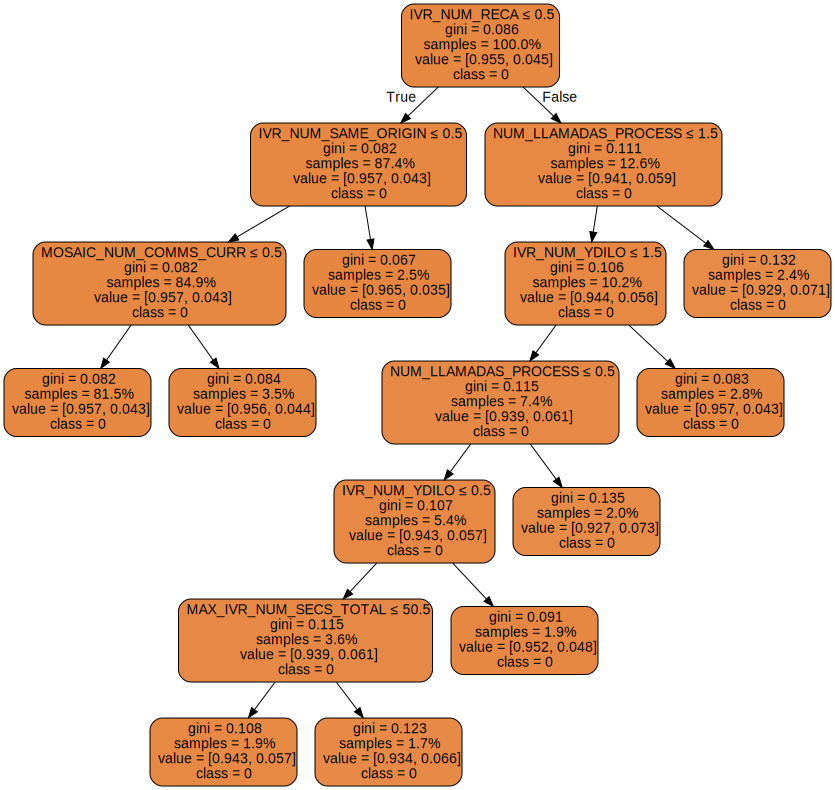

In [40]:
graph = graphviz.Source(dot_data)  
# #Para exportarlo a pdf graph.render("Arbol")
graph

In [41]:
# univariante para Num_llamada_Process

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [1]:
from sklearn import tree

In [2]:
# cortes con arbol sobre-ajustados (manteniendo el 100% de casos)
df_univar=df[['NUM_LLAMADAS_PROCESS','fuga_real']]

# se entrena arbol
# ========================================================
tree_model.fit(df_univar.NUM_LLAMADAS_PROCESS.to_frame(), df_univar.fuga_real)

# entrenamiento del modelo
# ========================================================
df_univar['NUM_LLAMADAS_PROCESS_PROB']=tree_model.predict_proba(df_univar.NUM_LLAMADAS_PROCESS.to_frame())[:,1] 

# Definición del modelo
# ========================================================
tree_model = DecisionTreeClassifier(max_depth=2)
tree_model.fit(df_univar.NUM_LLAMADAS_PROCESS.to_frame(), df_univar.fuga_real)
df_univar['NUM_LLAMADAS_PROCESS_PROB']=tree_model.predict_proba(df_univar.NUM_LLAMADAS_PROCESS.to_frame())[:,1] 

NameError: name 'df' is not defined

In [ ]:
cortes_sum=pd.concat( [df_univar.groupby(['NUM_LLAMADAS_PROCESS_PROB'])['NUM_LLAMADAS_PROCESS'].min(),                       
                       df_univar.groupby(['NUM_LLAMADAS_PROCESS_PROB'])['NUM_LLAMADAS_PROCESS'].max(),
                       df_univar.groupby(['NUM_LLAMADAS_PROCESS_PROB'])['NUM_LLAMADAS_PROCESS'].count(),
                       df_univar.groupby(['NUM_LLAMADAS_PROCESS_PROB'])['NUM_LLAMADAS_PROCESS'].mean(),
                       df_univar.groupby(['NUM_LLAMADAS_PROCESS_PROB'])['NUM_LLAMADAS_PROCESS'].std() ],axis=1
                    )
cortes_sum

In [ ]:
cortes_sum.columns

In [ ]:
cortes_sum.rename(columns={0: "Limite_MIN", 1: "Limite_MAX" , 2:"Clientes",3:"Mean",4:"STD"})

In [ ]:
#Cortes con un arbol train/test
df_univar=df[['NUM_LLAMADAS_PROCESS','fuga_real']]

# Se procede con train/test split
# ========================================================
X_train, X_test, y_train, y_test = train_test_split(df_univar[['NUM_LLAMADAS_PROCESS','fuga_real']],df_univar.fuga_real , test_size = 0.3, random_state=42)

# se entrena arbol
# ========================================================
tree_model.fit(X_train.NUM_LLAMADAS_PROCESS.to_frame(), X_train.fuga_real)


# entrenamiento del modelo
# ========================================================
X_train['NUM_LLAMADAS_PROCESS_PROB']=tree_model.predict_proba(X_train.NUM_LLAMADAS_PROCESS.to_frame())[:,1] 

# Definición del modelo
# ========================================================
tree_model = DecisionTreeClassifier(max_depth=2)
tree_model.fit(X_train.NUM_LLAMADAS_PROCESS.to_frame(), X_train.fuga_real)
X_train['NUM_LLAMADAS_PROCESS_PROB']=tree_model.predict_proba(X_train.NUM_LLAMADAS_PROCESS.to_frame())[:,1] 

# Generacion de cortes
# ========================================================
cortes=pd.concat( [X_train.groupby(['NUM_LLAMADAS_PROCESS_PROB'])['NUM_LLAMADAS_PROCESS'].min(),
             X_train.groupby(['NUM_LLAMADAS_PROCESS_PROB'])['NUM_LLAMADAS_PROCESS'].max()], axis=1)

cortes


In [ ]:
desde

#### DEFINICION DE REGLA 2

In [ ]:
X=df[['NUM_LLAMADAS_PROCESS',
 'IVR_NUM_SEGM',
 'IVR_NUM_YDILO',
 'IVR_NUM_AGENT',
 'IVR_NUM_ACD',
 'IVR_NUM_MDTEL',
 'IVR_NUM_CALLS',
 'IVR_NUM_CALL_IN',
#  'IVR_NUM_AGEN',
 'IVR_NUM_RECA',
#  'IVR_NUM_CALL_TRAN',
#  'IVR_NUM_RECA_AGEN',
#  'IVR_NUM_SAME_ORIGIN',
# 'IVR_NUM_SECS_TOTAL',
 # 'MAX_IVR_NUM_SEGM',
 'IVR_NUM_SECS_TALK_TIME',
 'CLAIMS',
 'TOTAL_BLUE_TICKETS',
 'BILLING_CLAIMS',
 'tiempo_hr_resolucion_reclamacion',
 'tiempo_hr_resolucion_incidencia',
 'total_jiras_cc',
 'IVR_NUM_SECS_TOTAL',
 'IVR_NUM_SECS_TALK_TIME',
# 'MAX_IVR_NUM_SECS_TOTAL',
# 'MOSAIC_NUM_COMM_WITHOUT_ISSUE_CURR',
 'MOSAIC_NUM_COMM_DEPT_ATC_CURR',
 'MAX_IVR_NUM_SECS_TALK_TIME',
# 'IVR_NUM_AGEN',
 # 'MOSAIC_NUM_COMM_WP_NO_ISSUE_CURR',
# 'MOSAIC_NUM_COMM_WP_GRP_NO_ISSUE_CURR',
 # 'MOSAIC_NUM_COMM_WP_GRP_UNKN_CURR',
#  'MOSAIC_NUM_COMMS_CURR',
 'ISSUE_CALL',
 'NUM_SERV_AGILETV_DAYS',
 'MOSAIC_NUM_COMM_WITH_ISSUE_CURR',
# 'MOSAIC_NUM_COMM_WP_GRP_TECH_CURR',
 'MOSAIC_NUM_COMM_WP_MOB_FAULT_CURR'  , 
       'NUM_DISC_CURR' #,
      
#       'DELTA_CLAIMS_6M_MONTH',
# 'IS_ACCO_BUND_LONGER_THAN_1_YEAR'
  ]]


Y=df[['fuga_real']].astype(str)


# Realizamos el train test split
# ======================================================
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)

n = len(X)

from sklearn.tree import DecisionTreeClassifier

# Indice de gini para arbol de decisión
# ======================================================
clf_gini = DecisionTreeClassifier(criterion = "gini",min_samples_leaf=2500) 

#clf=clf_entropy.fit(X_train, Y_train)
clf=clf_gini.fit(X_train, Y_train)


import graphviz 
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
import numpy as np

dot_data = tree.export_graphviz(clf, out_file = None,
                                feature_names = X_train.columns,
                                class_names = np.unique(Y_train),
                                filled=True,  rounded=True,  
                                proportion = True,
                         special_characters=True)

In [ ]:
graph = graphviz.Source(dot_data)  
# #Para exportarlo a pdf graph.render("Arbol")
graph

In [ ]:
# regla 2


In [ ]:
X=df[[ 
    
    
    'BILLING_CLAIMS',
 'CLAIMS',
 'TOTAL_BLUE_TICKETS',
 'tiempo_hr_resolucion_incidencia',
 'tiempo_hr_resolucion_reclamacion',
 'DELTA_CLAIMS_6M_MONTH',
 'total_jiras_cc',
    
    
    
     # nuevo 
    'IS_ACCO_BUND_LONGER_THAN_1_YEAR', 
    # Fin de nuevo
 'Jiras_Reclamacion_Movil',
 'MOSAIC_NUM_COMM_WP_FIX_FAULT_CURR',
 'MOBILE_INCIDENCES',
 'MOSAIC_NUM_COMM_WP_GRP_TECH_CURR',
 'MOSAIC_NUM_COMM_DEPT_FAULT_CURR',
 'MOSAIC_NUM_COMM_WITH_ISSUE_CURR',
 'TOTAL_BLUE_TICKETS',
 'MOSAIC_NUM_COMM_WP_PROCESS_CURR',
 'ISSUE_CALL',
 'MOSAIC_NUM_COMM_WP_GRP_NON_TECH_CURR',
 'IVR_NUM_SECS_TALK_TIME',
 'MOSAIC_NUM_COMM_WP_OTHERS_CURR',
 'NUM_LLAMADAS_NETWORK',
 'total_jiras_cc',
 'IVR_NUM_AGEN',
#  'IVR_NUM_ACD',
 'IVR_NUM_AGENT',
 'MOSAIC_NUM_COMM_WP_MOB_FAULT_CURR',
 'MOSAIC_NUM_COMM_DEPT_ATC_CURR',
 'MOSAIC_NUM_COMMS_CURR',
 'BILLING_CLAIMS',
 'NUM_LLAMADAS_PROCESS'
          ]]


Y=df[['fuga_real']].astype(str)


# Realizamos el train test split
# ======================================================
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1000)

n = len(X)

from sklearn.tree import DecisionTreeClassifier

# Indice de gini para arbol de decisión
# ======================================================
clf_gini = DecisionTreeClassifier(criterion = "gini",min_samples_leaf=3000) 

#clf=clf_entropy.fit(X_train, Y_train)
clf=clf_gini.fit(X_train, Y_train)

import graphviz 
from sklearn import tree


from sklearn.tree import DecisionTreeClassifier
import numpy as np

dot_data = tree.export_graphviz(clf, out_file = None,
                                feature_names = X_train.columns,
                                class_names = np.unique(Y_train),
                                filled=True,  rounded=True,  
                                proportion = True,
                         special_characters=True)

In [ ]:
graph = graphviz.Source(dot_data)  
# #Para exportarlo a pdf graph.render("Arbol")
graph

In [ ]:
import pydotplus
dot_data = tree.export_graphviz(clf, out_file = None,
                                feature_names = X_train.columns,
                                class_names = np.unique(Y_train),
                                filled=True,  rounded=True,  
                         special_characters=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"8,8!"')
pydot_graph.write_png('SEG_PROCESS_ISSUE_REGLA_1.png')

In [ ]:
# SE PROCEDE CON LA REGLA 2

In [ ]:
graph = graphviz.Source(dot_data)  
# #Para exportarlo a pdf graph.render("Arbol")
graph

In [ ]:
import pydotplus
dot_data = tree.export_graphviz(clf, out_file = None,
                                feature_names = X_train.columns,
                                class_names = np.unique(Y_train),
                                filled=True,  rounded=True,  
                         special_characters=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"8,8!"')
pydot_graph.write_png('SEG_PROCESS_ISSUE_REGLA_2.png')

In [ ]:
# FIN 

In [ ]:
# COMIENZO DE DISCRETIZACION DE VARIABLE UNIVARIANTE. 

In [ ]:
import pydotplus
dot_data = tree.export_graphviz(clf, out_file = None,
                                feature_names = X_train.columns,
                                class_names = np.unique(Y_train),
                                filled=True,  rounded=True,  
                         special_characters=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"8,8!"')
pydot_graph.write_png('SEG_PROCESS_ISSUE.png')

In [ ]:
# Genoma para apartado de variables seleccionadas


In [ ]:
# Discretizacion

In [ ]:
verificar('num_llamadas_proc')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['NUM_LLAMADAS_PROCESS', 'fuga_real']],df.fuga_real , test_size = 0.3)

In [ ]:
tree_model = DecisionTreeClassifier(max_depth=2)
tree_model.fit(X_train.NUM_LLAMADAS_PROCESS.to_frame(), X_train.fuga_real)
X_train['NUM_LLAMADAS_PROCESS_tree']=tree_model.predict_proba(X_train.NUM_LLAMADAS_PROCESS.to_frame())[:,1]

In [ ]:
X_train.head(10)

In [ ]:
tree_model

In [ ]:
X_train.NUM_LLAMADAS_PROCESS_tree.unique()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [ ]:
tree.plot_tree(clf.fit(X,Y))
plt.show()

In [ ]:
clf = clf.fit(X, Y)

fig, ax = plt.subplots(figsize=(20, 20))  # whatever size you want
tree.plot_tree(clf.fit(X, Y), ax=ax)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plot_tree(clf, fontsize=10, filled=True, proportion=True)

In [ ]:
dot_data = tree.export_graphviz(clf, 
                                filled=True,  rounded=True,  
                                proportion = True,
                         special_characters=True)

graph = graphviz.Source(dot_data)  
# #Para exportarlo a pdf graph.render("Arbol")
graph

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
with open("/home/jupyter/Segementacion /FINAL/tree_model.txt", "w") as f:
    f = export_graphviz(tree_model, out_file=f)


In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/home/jupyter/Segementacion /FINAL/tree_model3.png"
Image(filename = PATH , width=1000, height=1000)

-- FIN --